## Explore the cloud probability layer

In [ ]:
#%pip install geopandas pandas numpy matplotlib seaborn rasterio

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   --------- ------------------------------ 5.8/25.4 MB 27.5 MB/s eta 0:00:01
   ----------- ---------------------------- 7.6/25.4 MB 21.3 MB/s eta 0:00:01
   ------------------ --------------------- 11.5/25.4 MB 19.1 MB/s eta 0:00:01
   ------------------------- -------------- 16.5/25.4 MB 19.1 MB/s eta 0:00:01
   ---------------------------------------  25.2/25.4 MB 23.5 MB/s eta 0:00:01
   ---------------------------------------- 25.4/25.4 MB 21.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 30.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   ------------------ --------------------- 8.7/19.2 MB 41.5 MB/s eta 0:00:01
   --------------------------------- ------

In [ ]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from rasterio.plot import show

In [ ]:
# Setup paths
print("Current directory:", os.getcwd())
os.chdir(r"D:\OneDrive\DataProduct-SPF") # Change directory here. 
print("Working directory:", os.getcwd())

Current directory: d:\OneDrive\DataProduct-SPF\demo
Working directory: D:\OneDrive\DataProduct-SPF


In [ ]:
# Load data
raster_path = r'data_raw\cloud_probability_flipped.tif'
# lsoa_clipped = gpd.read_file('path/to/your/lsoa.shp')  # Update this if using a clipped data file from the beginning

# Check raster
with rasterio.open(raster_path) as src:
    print(f"Bands: {src.count}")
    print(f"CRS: {src.crs}")
    print(f"Shape: {src.shape}")
    print(f"Nodata: {src.nodata}")
    raster_crs = src.crs

Bands: 2
CRS: EPSG:27700
Shape: (2024, 3015)
Nodata: None


In [ ]:
lsoa_shp = gpd.read_file(r"data_raw/uk_datazones.gpkg/uk_datazones.gpkg") # All UK datazones. 

In [ ]:
#Filter for Newcastle OR Gateshead
from shapely import box
# Open raster and get its bounding box
raster_path = r'data_raw/cloud_Newcastle_2024.tif'  # Update path to cloud raster

with rasterio.open(raster_path) as src:
    print(f"\nRaster CRS: {src.crs}")
    print(f"Raster bounds: {src.bounds}")
    
    # Create a bounding box polygon from raster extent
    raster_bbox = box(src.bounds.left, src.bounds.bottom, 
                      src.bounds.right, src.bounds.top)
    
    # Convert to GeoDataFrame
    raster_bbox_gdf = gpd.GeoDataFrame({'geometry': [raster_bbox]}, crs=src.crs)
    
    # Reproject LSOA to match raster CRS if needed
    if lsoa_shp.crs != src.crs:
        print(f"\nReprojecting LSOA from {lsoa_shp.crs} to {src.crs}")
        lsoa_shp = lsoa_shp.to_crs(src.crs)
    
    # Clip LSOAs to raster extent using spatial intersection
    print("\nClipping LSOAs to raster extent...")
    lsoa_clipped = gpd.clip(lsoa_shp, raster_bbox_gdf)
    
  
    print(f"LSOAs within raster extent: {len(lsoa_clipped)}")


Raster CRS: EPSG:27700
Raster bounds: BoundingBox(left=399980.0, bottom=580240.0, right=460280.0, top=539760.0)

Clipping LSOAs to raster extent...
LSOAs within raster extent: 1004


<Axes: >

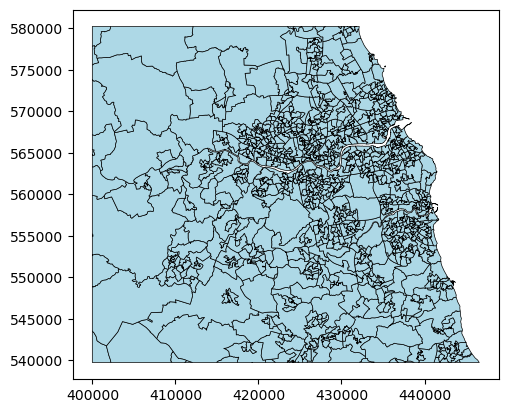

In [9]:
# Visualise clipped LSOAs
lsoa_clipped.plot(edgecolor='black', facecolor='lightblue', linewidth=0.5)


✓ Flipped raster saved to: data_raw/cloud_probability_flipped.tif


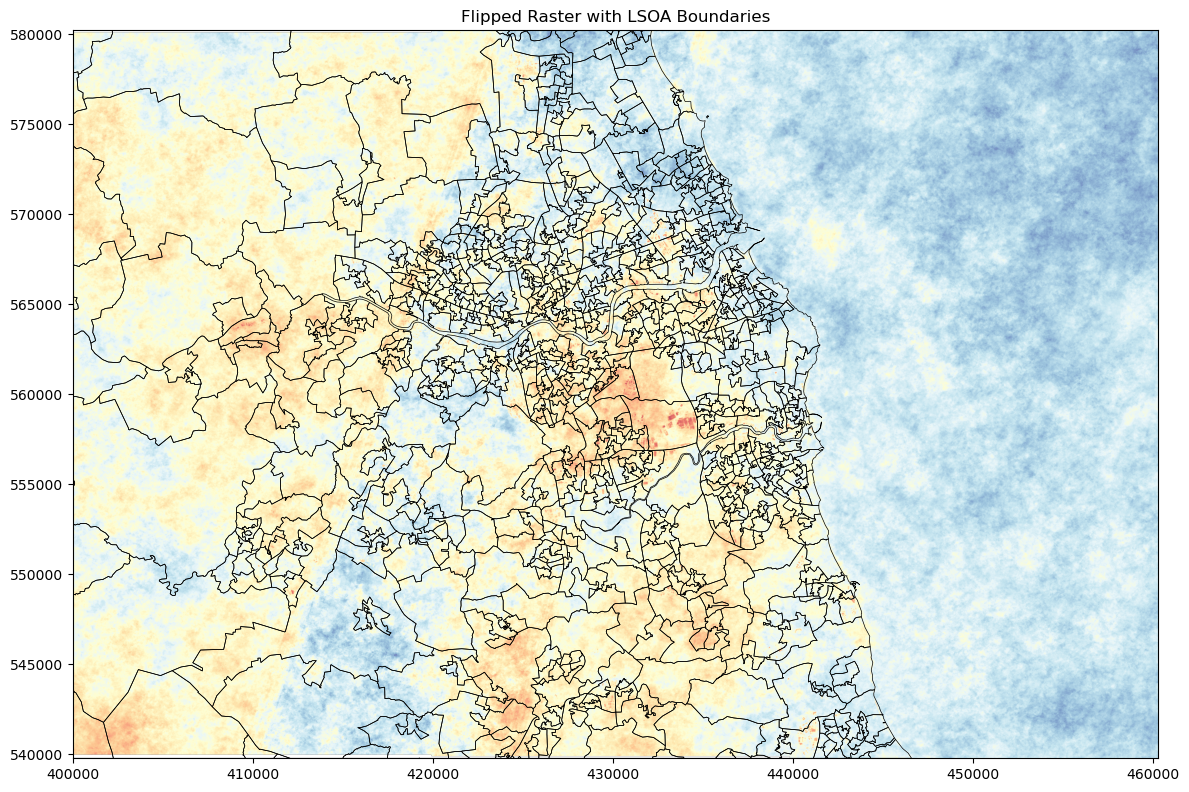

In [ ]:
# Read the upside-down raster (rasters sometimes have flipped origins, hence transfrom is required)
output_path = r'data_raw/cloud_probability_flipped.tif'

with rasterio.open(raster_path) as src:
    # Read all bands and flip vertically
    data = src.read()
    data_flipped = np.flip(data, axis=1)  # Flip along height axis
    
    # Get the transform and flip it
    transform = src.transform
    
    # Create new transform with positive Y resolution
    new_transform = rasterio.Affine(
        transform.a,  # x resolution (same)
        transform.b,  # rotation (same)
        transform.c,  # x origin (same)
        transform.d,  # rotation (same)
        -abs(transform.e),  # y resolution (make positive)
        transform.f + (src.height * transform.e)  # y origin (adjust)
    )
    
    # Copy metadata and update
    meta = src.meta.copy()
    meta.update({
        'transform': new_transform
    })
    
    # Write flipped raster
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(data_flipped)

print(f"✓ Flipped raster saved to: {output_path}")

# Now visualize to confirm
fig, ax = plt.subplots(figsize=(12, 12))

with rasterio.open(output_path) as src:
    lsoa_plot = lsoa_clipped.to_crs(src.crs)
    show(src, ax=ax, cmap='RdYlBu_r', alpha=0.7)
    lsoa_plot.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

plt.title('Flipped Raster with LSOA Boundaries')
plt.tight_layout()
plt.show()

In [ ]:
# Paths
raster_path = r'data_raw/cloud_probability_flipped.tif'  # corrected raster

# Check raster bands
with rasterio.open(raster_path) as src:
    print(f"Number of bands: {src.count}")
    print(f"CRS: {src.crs}")
    print(f"Bounds: {src.bounds}")
    print(f"Shape: {src.shape}")
    print(f"Nodata value: {src.nodata}")

Number of bands: 2
CRS: EPSG:27700
Bounds: BoundingBox(left=399980.0, bottom=539760.0, right=460280.0, top=580240.0)
Shape: (2024, 3015)
Nodata value: None


In [12]:
# Ensure LSOA boundaries are in same CRS as raster
with rasterio.open(raster_path) as src:
    raster_crs = src.crs

lsoa_proj = lsoa_clipped.to_crs(raster_crs)

In [ ]:
def calculate_weighted_zonal_stats(raster_path, zones_gdf, lsoa_id_col='LSOA21CD'):
    """
    Calculate weighted zonal statistics for cloud probability.
    
    Parameters:
    -----------
    raster_path : str
        Path to multiband raster (band 1: cloud prob, band 2: acquisitions)
    zones_gdf : GeoDataFrame
        LSOA boundaries
    lsoa_id_col : str
        Column name for LSOA identifier
    
    Returns:
    --------
    GeoDataFrame with weighted statistics
    """
    
    results = []
    
    with rasterio.open(raster_path) as src:
        # Reproject zones to match raster CRS
        zones_proj = zones_gdf.to_crs(src.crs)
        
        print(f"Processing {len(zones_proj)} zones...")
        
        for idx, row in zones_proj.iterrows():
            if idx % 100 == 0:
                print(f"  Processing zone {idx}/{len(zones_proj)}...")
            
            try:
                geom = [mapping(row.geometry)]
                
                # Extract both bands for this zone
                cloud_data, cloud_transform = mask(
                    src, geom, crop=True, indexes=1, nodata=src.nodata
                )
                weight_data, _ = mask(
                    src, geom, crop=True, indexes=2, nodata=src.nodata
                )
                
                # Flatten arrays to make weighting 
                cloud_flat = cloud_data.flatten()
                weight_flat = weight_data.flatten()
                
                # Create valid mask (exclude nodata and zero weights)
                if src.nodata is not None:
                    valid_mask = (
                        (cloud_flat != src.nodata) & 
                        (weight_flat != src.nodata) & 
                        (weight_flat > 0)
                    )
                else:
                    valid_mask = weight_flat > 0
                
                if valid_mask.sum() > 0:
                    cloud_valid = cloud_flat[valid_mask]
                    weight_valid = weight_flat[valid_mask]
                    
                    # Calculate weighted mean: Σ(cloud_prob × acquisitions in pixel) / Σ(acquisitions in lsoa)
                    weighted_mean = np.sum(cloud_valid * weight_valid) / np.sum(weight_valid)
                    
                    # Calculate unweighted mean for comparison
                    unweighted_mean = np.mean(cloud_valid)
                    
                    # Additional statistics
                    total_acquisitions = np.sum(weight_valid)
                    avg_acquisitions_per_pixel = np.mean(weight_valid)
                    pixel_count = valid_mask.sum()
                    
                    # Standard deviation (weighted)
                    weighted_variance = np.sum(weight_valid * (cloud_valid - weighted_mean)**2) / np.sum(weight_valid)
                    weighted_std = np.sqrt(weighted_variance)
                    
                else:
                    weighted_mean = np.nan
                    unweighted_mean = np.nan
                    total_acquisitions = 0
                    avg_acquisitions_per_pixel = 0
                    pixel_count = 0
                    weighted_std = np.nan
                
                results.append({
                    lsoa_id_col: row[lsoa_id_col],
                    'weighted_cloud_prob': weighted_mean,
                    'unweighted_cloud_prob': unweighted_mean,
                    'weighted_std': weighted_std,
                    'total_acquisitions': total_acquisitions,
                    'avg_acquisitions_per_pixel': avg_acquisitions_per_pixel,
                    'pixel_count': pixel_count,
                    'difference_weighted_unweighted': weighted_mean - unweighted_mean
                })
                
            except Exception as e:
                print(f"  Error processing zone {idx} ({row.get(lsoa_id_col, 'unknown')}): {e}")
                results.append({
                    lsoa_id_col: row[lsoa_id_col],
                    'weighted_cloud_prob': np.nan,
                    'unweighted_cloud_prob': np.nan,
                    'weighted_std': np.nan,
                    'total_acquisitions': 0,
                    'avg_acquisitions_per_pixel': 0,
                    'pixel_count': 0,
                    'difference_weighted_unweighted': np.nan
                })
    
    print("✓ Processing complete!")
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Merge with original GeoDataFrame
    zones_with_stats = zones_gdf.merge(results_df, on=lsoa_id_col, how='left')
    
    return zones_with_stats

In [ ]:
# Run the calculation
lsoa_with_stats = calculate_weighted_zonal_stats(
    raster_path=raster_path,
    zones_gdf=lsoa_clipped,
    lsoa_id_col='LSOA21CD'  # Adjust for zone
)

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nTotal LSOAs: {len(lsoa_with_stats)}")
print(f"LSOAs with valid data: {lsoa_with_stats['weighted_cloud_prob'].notna().sum()}")
print(f"\nWeighted Cloud Probability Stats:")
print(lsoa_with_stats['weighted_cloud_prob'].describe())
print(f"\nTotal Acquisitions Stats:")
print(lsoa_with_stats['total_acquisitions'].describe())

Processing 1004 zones...
  Processing zone 19600/1004...
  Processing zone 8300/1004...
  Processing zone 7800/1004...
  Processing zone 8000/1004...
  Processing zone 8100/1004...
  Processing zone 19700/1004...
  Processing zone 8400/1004...
  Processing zone 8200/1004...
  Processing zone 7900/1004...
✓ Processing complete!

SUMMARY STATISTICS

Total LSOAs: 1004
LSOAs with valid data: 1001

Weighted Cloud Probability Stats:
count    1001.000000
mean       58.230828
std         2.788509
min        48.778721
25%        56.593246
50%        58.269615
75%        60.101101
max        66.160629
Name: weighted_cloud_prob, dtype: float64

Total Acquisitions Stats:
count    1.004000e+03
mean     6.718430e+05
std      2.300858e+06
min      0.000000e+00
25%      1.095912e+05
50%      1.982510e+05
75%      4.140262e+05
max      3.921076e+07
Name: total_acquisitions, dtype: float64


In [15]:
# Preview results
print("\nFirst 10 results:")
display_cols = [
    'LSOA21CD', 
    'weighted_cloud_prob', 
    'unweighted_cloud_prob',
    'difference_weighted_unweighted',
    'total_acquisitions', 
    'pixel_count'
]
print(lsoa_with_stats[display_cols].head(10))


First 10 results:
    LSOA21CD  weighted_cloud_prob  unweighted_cloud_prob  \
0  E01020893            52.978081              52.978081   
1  E01020892            59.132538              59.128994   
2  E01034493            59.651073              59.651073   
3  E01020724            60.663326              60.663322   
4  E01033197            59.650764              59.650768   
5  E01020723            60.909405              60.909412   
6  E01033195            60.365646              60.365646   
7  E01020693            62.500542              62.500546   
8  E01034499            61.561138              61.570896   
9  E01020686            62.109135              61.971588   

   difference_weighted_unweighted  total_acquisitions  pixel_count  
0                        0.000000            175602.0         2373  
1                        0.003544              1343.0           18  
2                        0.000000           1486426.0        10181  
3                        0.000004           

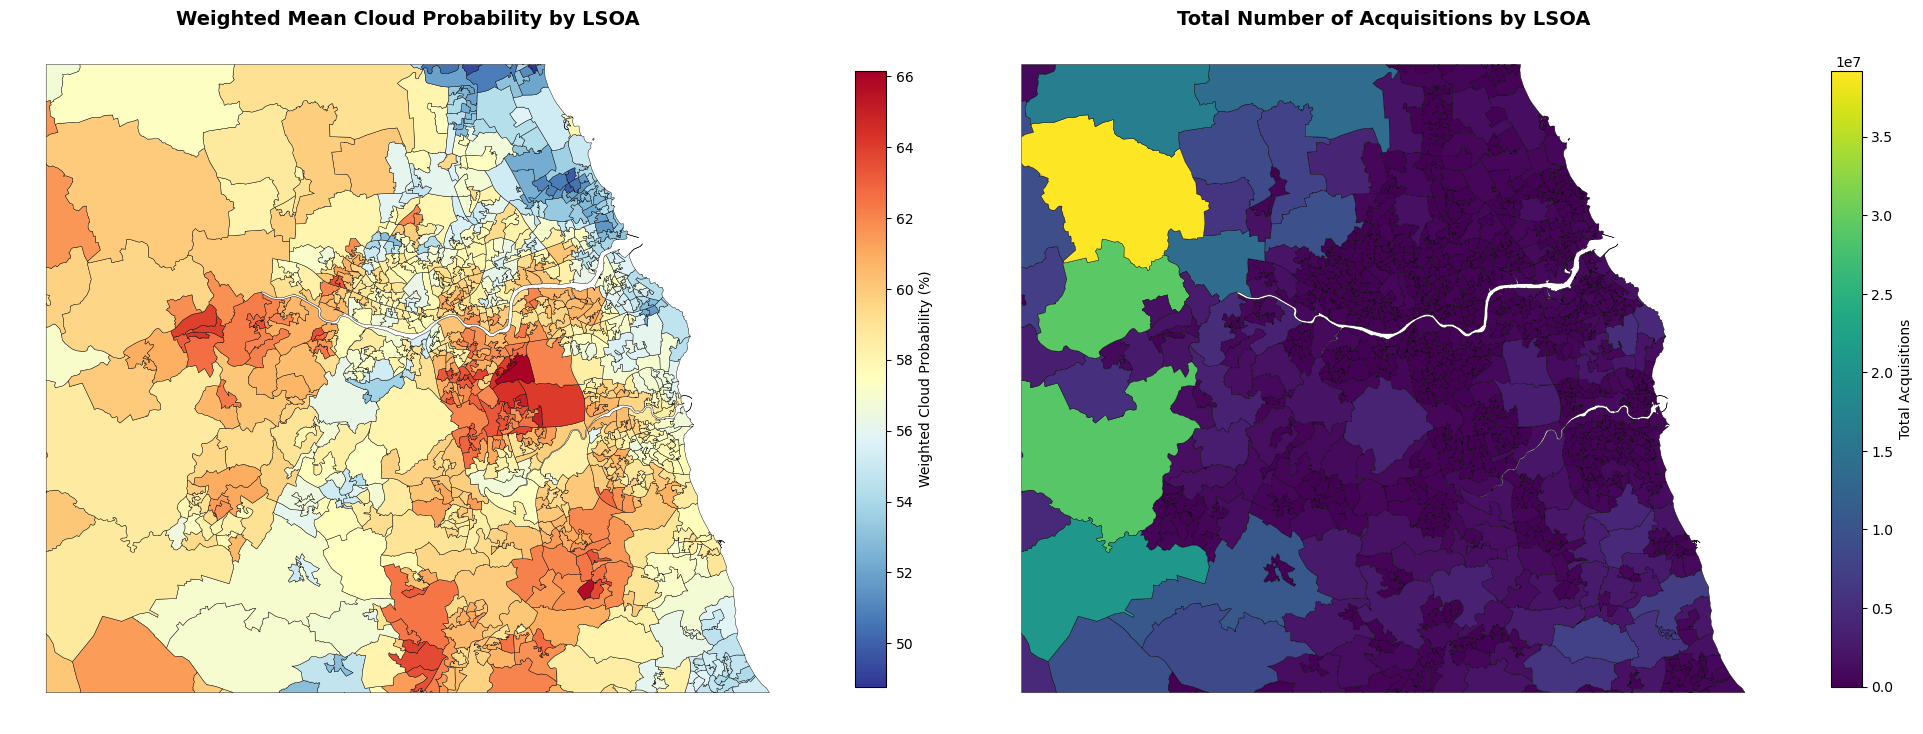

In [24]:
# Create maps
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Map 1: Weighted cloud probability
lsoa_with_stats.plot(
    column='weighted_cloud_prob',
    ax=axes[0],
    legend=True,
    cmap='RdYlBu_r',
    edgecolor='black',
    linewidth=0.3,
    legend_kwds={'label': 'Weighted Cloud Probability (%)', 'shrink': 0.8},
    missing_kwds={'color': 'lightgrey'}
)
axes[0].set_title('Weighted Mean Cloud Probability by LSOA', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Map 2: Total acquisitions
lsoa_with_stats.plot(
    column='total_acquisitions',
    ax=axes[1],
    legend=True,
    cmap='viridis',
    edgecolor='black',
    linewidth=0.3,
    legend_kwds={'label': 'Total Acquisitions', 'shrink': 0.8},
    missing_kwds={'color': 'lightgrey'}
)
axes[1].set_title('Total Number of Acquisitions by LSOA', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('demo/illustrations/lsoa_cloud_maps.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\spspa\AppData\Local\Temp\ipykernel_21748\121284479.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(data_to_plot, labels=['Weighted', 'Unweighted'], patch_artist=True)


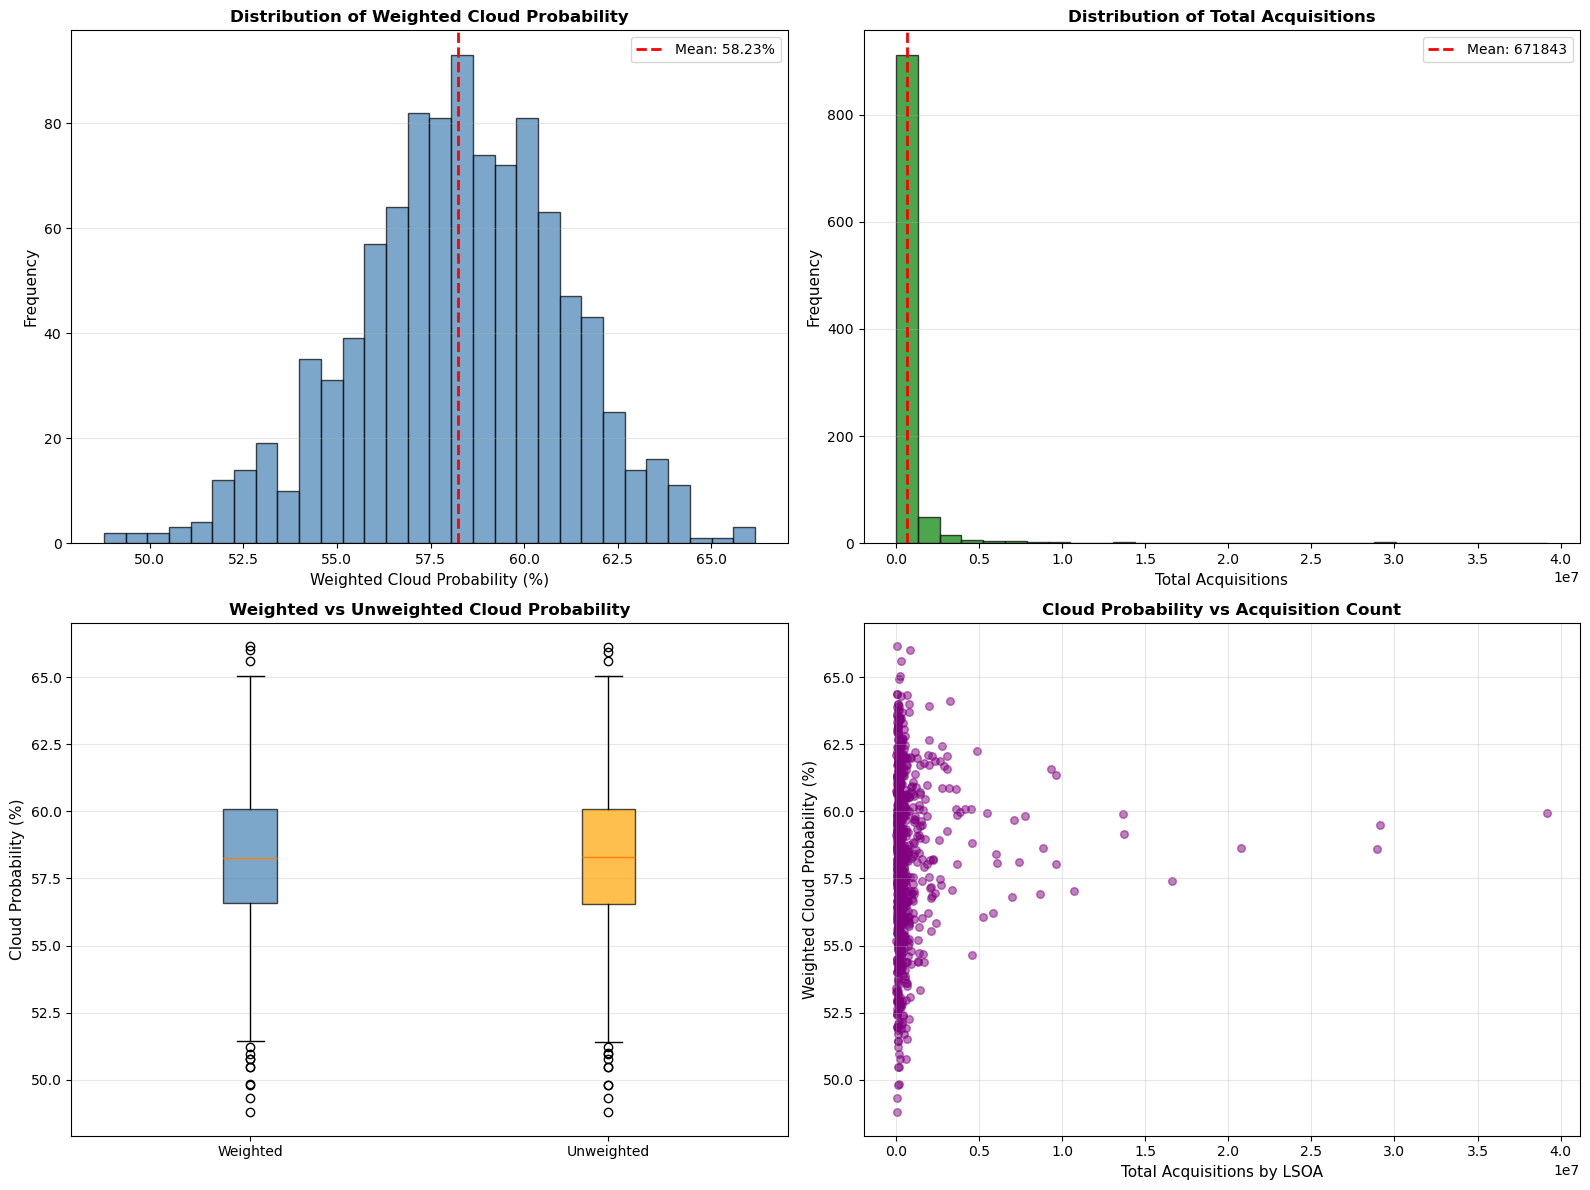

In [28]:
# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram: Weighted cloud probability
axes[0, 0].hist(
    lsoa_with_stats['weighted_cloud_prob'].dropna(), 
    bins=30, 
    edgecolor='black', 
    alpha=0.7,
    color='steelblue'
)
axes[0, 0].axvline(
    lsoa_with_stats['weighted_cloud_prob'].mean(), 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label=f'Mean: {lsoa_with_stats["weighted_cloud_prob"].mean():.2f}%'
)
axes[0, 0].set_xlabel('Weighted Cloud Probability (%)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Weighted Cloud Probability', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Histogram: Total acquisitions
axes[0, 1].hist(
    lsoa_with_stats['total_acquisitions'].dropna(), 
    bins=30, 
    edgecolor='black', 
    alpha=0.7,
    color='green'
)
axes[0, 1].axvline(
    lsoa_with_stats['total_acquisitions'].mean(), 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label=f'Mean: {lsoa_with_stats["total_acquisitions"].mean():.0f}'
)
axes[0, 1].set_xlabel('Total Acquisitions', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Total Acquisitions', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Boxplot: Weighted vs Unweighted
data_to_plot = [
    lsoa_with_stats['weighted_cloud_prob'].dropna(),
    lsoa_with_stats['unweighted_cloud_prob'].dropna()
]
bp = axes[1, 0].boxplot(data_to_plot, labels=['Weighted', 'Unweighted'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['steelblue', 'orange']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_ylabel('Cloud Probability (%)', fontsize=11)
axes[1, 0].set_title('Weighted vs Unweighted Cloud Probability', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Scatter: Acquisitions vs Cloud Probability
axes[1, 1].scatter(
    lsoa_with_stats['total_acquisitions'],
    lsoa_with_stats['weighted_cloud_prob'],
    alpha=0.5,
    s=30,
    color='purple'
)
axes[1, 1].set_xlabel('Total Acquisitions by LSOA', fontsize=11)
axes[1, 1].set_ylabel('Weighted Cloud Probability (%)', fontsize=11)
axes[1, 1].set_title('Cloud Probability vs Acquisition Count', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('demo/illustrations/distribution_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
output_gpkg = 'data_raw/lsoa_cloud_stats.gpkg'
lsoa_with_stats.to_file(output_gpkg, driver='GPKG')

##### Splitting raster bands - snippet

In [22]:
def split_bands(input_raster, output_prefix='band'):
    """
    Split a multiband raster into separate single-band files.
    
    Parameters:
    -----------
    input_raster : str
        Path to multiband raster
    output_prefix : str
        Prefix for output files (default: 'band')
    
    Returns:
    --------
    List of output file paths
    """
    
    output_files = []
    
    with rasterio.open(input_raster) as src:
        # Get metadata
        meta = src.meta.copy()
        meta.update(count=1)  # Single band output
        
        print(f"Splitting {src.count} bands from: {input_raster}")
        
        # Split each band
        for band_num in range(1, src.count + 1):
            # Read the band
            band_data = src.read(band_num)
            
            # Create output filename
            output_file = f"{output_prefix}_{band_num}.tif"
            
            # Write to new file
            with rasterio.open(output_file, 'w', **meta) as dst:
                dst.write(band_data, 1)
            
            output_files.append(output_file)
            print(f"  ✓ Band {band_num} saved to: {output_file}")
    
    print(f"\n✓ All bands split successfully!")
    return output_files


In [ ]:
# Usage example
input_raster = r'data_raw\cloud_probability_flipped.tif'

# Option 1: Default naming (band_1.tif, band_2.tif)
split_bands(input_raster)

# Option 2: Custom naming
split_bands(
    input_raster, 
    output_prefix=r'data_raw\cloud_Newcastle_2024'
)
# Creates: cloud_Newcastle_2024_1.tif, cloud_Newcastle_2024_2.tif

Splitting 2 bands from: data_raw\cloud_probability_flipped.tif
  ✓ Band 1 saved to: band_1.tif
  ✓ Band 2 saved to: band_2.tif

✓ All bands split successfully!
Splitting 2 bands from: data_raw\cloud_probability_flipped.tif
  ✓ Band 1 saved to: data_raw\cloud_Newcastle_2024_1.tif
  ✓ Band 2 saved to: data_raw\cloud_Newcastle_2024_2.tif

✓ All bands split successfully!


['data_raw\\cloud_Newcastle_2024_1.tif',
 'data_raw\\cloud_Newcastle_2024_2.tif']